This notebook is an implementation of using a MLP models to ensemble output from different folds of predictions of same model. I refer to this method as `MetaClassifier` in this notebook

**Idea**
- Generally the predictions from different folds is averaged to get the final predicition
- Here we train a separate model (Plain Feedforward NNs) to calculate the final prediction from different fold predictions
- Input is prediction probabilities from different folds, output is target label
- Entire dataset is Stratified split into train, validation and test sets 
- A 3-layer NN with Batchnorm and droput is trained using SGD optimizer, CosineAnnealingWarmRestarts lr_scheduler
- The results on test set (overall accuracy and confusion matrix) of the averaging method and the MetaClassifier approach

**Notebook reference**
- Much of notebook is inspired from this [blog post](https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab)

***Feedback is most welcome***

## Library imports

In [1]:
# basic imports
import os
import numpy as np
import pandas as pd
import random
import itertools
from tqdm.notebook import tqdm
import math
from scipy.special import softmax


# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# metrics calculation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# basic plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot # download_plotlyjs, plot
init_notebook_mode(connected=True)

## Constants

In [2]:
index_label_map = {
                0: "CBB",    # Cassava Bacterial Blight 
                1: "CBSD",   # Cassava Brown Streak Disease 
                2: "CGM",    # Cassava Green Mottle
                3: "CMD",    # Cassava Mosaic Disease 
                4: "Healthy"
                }

class_names = [value for key,value in index_label_map.items()]
print(class_names)

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


In [3]:
SEED = 42
N_FOLDS = 5 
N_EPOCHS = 25
N_FEATURES = 25
N_CLASSES = len(class_names)
TRAINVAL_TEST_SPLIT = 0.6
TRAIN_VAL_SPLIT = 0.6

LEARNING_RATE = 1e-3
DROPOUT_PROB = 0.4
BATCH_SIZE = 16

LR_FIND = False
TRAIN   = False
PRINT_EVERY = 5
WGT_SAVE_DIR = 'Meta classifier models'

## Helper function

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def seed_reproducer(seed=2020):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = True
seed_reproducer(SEED)

In [6]:
def get_class_distribution(obj):
    count_dict = {}
    for label in class_names:
        count_dict[label] = 0
    
    for i in obj:
        if i in range(N_CLASSES): 
            count_dict[class_names[i]] += 1
    return count_dict

## Creating data

In [7]:
"""
val_folder = '../input/se-resnext50-model-predictions-and-labels/'
model_name = 'se_rexnext50'

preds = []
labels = []
for fold in range(N_FOLDS):
    preds.append(np.load(f'{val_folder}{model_name}_fold{fold}_preds.npy'))
    labels.append(np.load(f'{val_folder}{model_name}_fold{fold}_labels.npy'))

# labels is same for all folds as input is not shuffled    
labels = np.array(labels[0])

# stacking the predictions
preds = np.array(preds)
preds = np.moveaxis(preds, 0, -1)
preds = preds.reshape((len(preds), -1))
"""

oof_preds = np.load('oof_preds.npy')
oof_labels = np.load('oof_labels.npy')

def input_preprocess(x):
    output = np.zeros((x.shape[1], 25))
    for i in range(x.shape[1]):
        output[i] = x[:,i,:].flatten()    
    return output

X shape = (21397, 25), y shape = (21397,)


/home/wabco/miniconda3/envs/lyft/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:ylabel='count'>

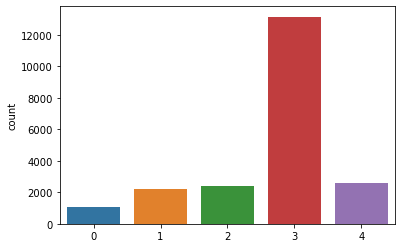

In [8]:
# verify input and output shape
X = input_preprocess(oof_preds)
y = oof_labels
print(f'X shape = {X.shape}, y shape = {y.shape}')

# Make sure the input limits are scaled
#print(f'X max value is {X.max(axis=0)}, X min value is {X.min(axis=0)}')

# output label distribution
sns.countplot(y)

## Split train into train and val sets

Text(0.5, 1.0, 'Class Distribution in Test Set')

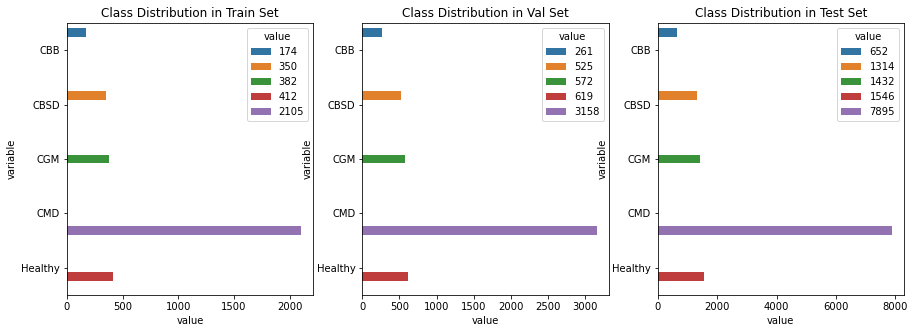

In [9]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=TRAINVAL_TEST_SPLIT, stratify=y, random_state=SEED)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=TRAIN_VAL_SPLIT, stratify=y_trainval, random_state=SEED)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "value", y="variable", hue="value",ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(),   x = "value", y="variable", hue="value",ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(),  x = "value", y="variable", hue="value",ax=axes[2]).set_title('Class Distribution in Test Set')

## Dataset

In [10]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Weighted class samplers and Dataloaders

In [11]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0057, 0.0029, 0.0026, 0.0005, 0.0024])


In [12]:
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE) #sampler=weighted_sampler
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

## Metaclassifier

In [13]:
class MetaClassifier(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MetaClassifier, self).__init__()
        self.layer_1 = nn.Linear(num_feature, 32)
        self.layer_2 = nn.Linear(32, 16)
        self.layer_3 = nn.Linear(16, 8)
        self.layer_out = nn.Linear(8, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_PROB)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(16)
        self.batchnorm3 = nn.BatchNorm1d(8)
        
    def forward(self, x):
        #print(x.shape)
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        return x

## device, optimizer

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MetaClassifier(num_feature = N_FEATURES, num_class=N_CLASSES)
model.to(device)
#print(model)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-5)

cuda:0


## Evaluation metric function

In [15]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.softmax(y_pred, dim = 1)
    y_pred_tags = torch.argmax(y_pred_softmax, dim = 1)    
    #_, y_pred_tags = torch.argmax(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc

accuracy_stats = { 'train': [], "val": [] }
loss_stats = { 'train': [], "val": [] }
best_val_acc = 0.0
best_epoch = 0

## Lr_find function

In [16]:
def plot_lr_finder_results(lr_finder): 
    # Create subplot grid
    fig = make_subplots(rows=1, cols=2)
    # layout ={'title': 'Lr_finder_result'}
    
    # Create a line (trace) for the lr vs loss, gradient of loss
    trace0 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['smooth_loss'],name='log_lr vs smooth_loss')
    trace1 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['grad_loss'],name='log_lr vs loss gradient')

    # Add subplot trace & assign to each grid
    fig.add_trace(trace0, row=1, col=1);
    fig.add_trace(trace1, row=1, col=2);
    iplot(fig, show_link=False)
    #fig.write_html(model_cfg['model_name'] + '_lr_find.html');

In [17]:
def find_lr(model, data_loader, optimizer, init_value = 1e-8, final_value=100.0, beta = 0.98, num_batches = 200):
    assert(num_batches > 0)
    mult = (final_value / init_value) ** (1/num_batches)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    batch_num = 0
    avg_loss = 0.0
    best_loss = 0.0
    smooth_losses = []
    raw_losses = []
    log_lrs = []
    dataloader_it = iter(data_loader)
    progress_bar = tqdm(range(num_batches))
        
    for idx in progress_bar:
        batch_num += 1
        try:
            X, y = next(dataloader_it)
            #print(images.shape)
        except:
            dataloader_it = iter(data_loader)
            X, y = next(dataloader_it)

        # Move input and label tensors to the default device
        X = X.to(device, dtype=torch.float)
        y = y.to(device)
        
        # handle exception in criterion
        try:
            # Forward pass
            y_hat = model(X)
            loss = criterion(y_hat, y)
        except:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results 
                    
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 50 * best_loss:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        raw_losses.append(loss.item())
        smooth_losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print info
        progress_bar.set_description(f"loss: {loss.item()},smoothed_loss: {smoothed_loss},lr : {lr}")

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    grad_loss = np.gradient(smooth_losses)
    lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                         'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
    return lr_finder_results

In [18]:
if LR_FIND == True:
    lr_finder_results = find_lr(model, train_loader, optimizer)
    plot_lr_finder_results(lr_finder_results)

In [19]:
## Training function

In [20]:
print("Begin training.")
iters = len(train_loader)
for e in tqdm(range(1, N_EPOCHS+1)):
    ## TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        # forward pass
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        # log results
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

        # backward pass
        train_loss.backward()
        optimizer.step()
        scheduler.step(e + i / iters)
        
        
    ## VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)    
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            # log results
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    #scheduler.step(val_loss.item())
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    if((val_epoch_acc/len(val_loader)) > best_val_acc):
        torch.save(model.state_dict(), f'{WGT_SAVE_DIR}/MetaClassifier_epoch{e}.pth')
        best_val_acc = (val_epoch_acc/len(val_loader))
        best_epoch = e
    
    if (e % PRINT_EVERY) == 0:
        print(f'Epoch {e+0:3}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch   5: | Train Loss: 0.97209 | Val Loss: 0.63097 | Train Acc: 95.794| Val Acc: 93.574
Epoch  10: | Train Loss: 0.83907 | Val Loss: 0.36795 | Train Acc: 99.065| Val Acc: 94.800
Epoch  15: | Train Loss: 0.79591 | Val Loss: 0.32245 | Train Acc: 98.598| Val Acc: 94.878
Epoch  20: | Train Loss: 0.74886 | Val Loss: 0.24450 | Train Acc: 99.533| Val Acc: 94.976
Epoch  25: | Train Loss: 0.70367 | Val Loss: 0.24410 | Train Acc: 99.533| Val Acc: 94.937



In [22]:
print(f'Best val_acc occured at epoch : {best_epoch}, val_acc : {best_val_acc}')
model.load_state_dict(torch.load(f'{WGT_SAVE_DIR}/MetaClassifier_epoch10.pth', map_location=device))

Best val_acc occured at epoch : 17, val_acc : 95.05355404089582


<All keys matched successfully>

## Plot results

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

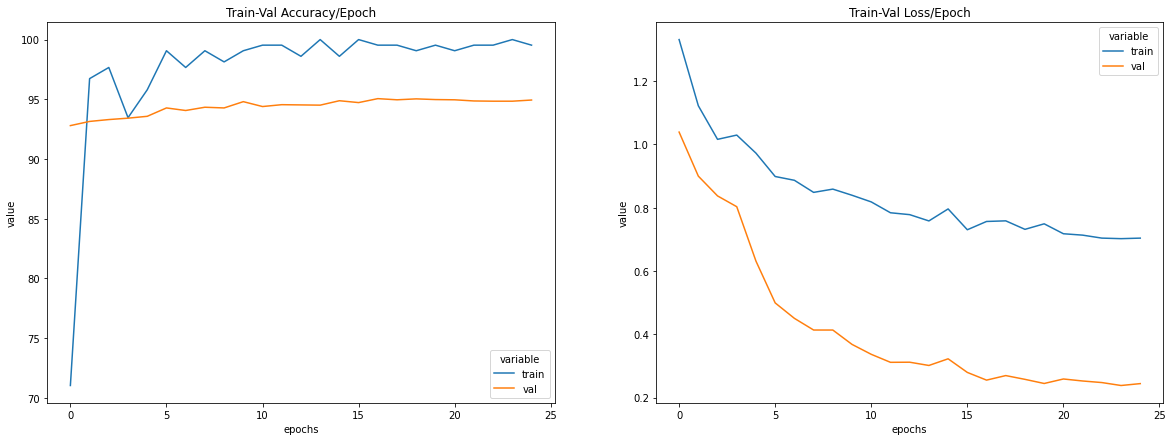

In [23]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test set results

In [24]:
def accuracy_avg_method(X_pred, y_true):
    fold_split = np.array(np.split(X_pred, 5, axis=1)) # (5, -1, 5)
    # X_test[0] ~~ fold_split[:,0,:]
    classwise_avg = np.average(fold_split, axis=0)
    #print(classwise_avg.shape)
    # print(classwise_avg[0]), # should point out first test label    
    y_preds_softmax = softmax(classwise_avg, axis=1)
    #print(y_preds_softmax.shape)
    y_pred_tags = np.argmax(y_preds_softmax, axis=1)
    print(f'avgmethod accuracy = {100.0 * accuracy_score(y_test, y_pred_tags)}')
    avgmethod_cm = confusion_matrix(y_test, y_pred_tags)
    plot_confusion_matrix(avgmethod_cm, class_names, normalize=True, title='avgmethod Confusion matrix')

## **MetaClassifier performance**

MetaClassifier accuracy = 94.17400109042761
Normalized confusion matrix


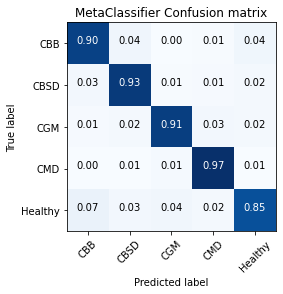

In [27]:
model.load_state_dict(torch.load(f'{WGT_SAVE_DIR}/MetaClassifier_epoch{best_epoch}.pth',map_location=device))

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)        
        y_pred_softmax = torch.softmax(y_test_pred, dim = 1)
        y_pred_tags = torch.argmax(y_pred_softmax, dim = 1)    
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(f'MetaClassifier accuracy = {100.0 * accuracy_score(y_test, y_pred_list)}')

# confusion matrix 
MetaClassifier_cm = confusion_matrix(y_test, y_pred_list)
plot_confusion_matrix(MetaClassifier_cm, class_names, normalize=True, title='MetaClassifier Confusion matrix')

avgmethod accuracy = 93.4496456110289
Normalized confusion matrix


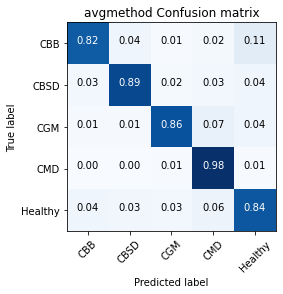

In [29]:
accuracy_avg_method(X_test, y_test)

## Results

> **The MetaClassifier approach seems to have a lower overall accuracy, but is more accuracy in predicting the minority classes - label0(CBB) and label4(Healthy). This could be an option for ensembling different folds of the same model as well as ensembling different model outputs.**